### Convolutional NN for the Fashion-MNIST dataset

* Methodology adapted from fastai developed by Jeremy Howard
* Trained on GPU machine
* dataset has fashion images for 10 different product categories, 60K training images and 10K validation images
* we leverage a pretrained **RESNET 34** for our convolutional layers
* achieves ~89% accuracy without significant customization of model

In [43]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [44]:
from fastai.imports import *

In [45]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [46]:
# set path and size of image to 224
PATH='data/'
sz=224

### We precompute the activations of the convolutional layers from RESNET 34 so that the training is done speedily
* delete tmp directory to ensure computation of pre-activations

### In order to find the optimal learning rate, we adopt an approach outlined in _cyclical learning rates for NN_ by Leslie Smith
* start with a very low learning rate
* increase LR e.g. by doubling and track the loss
* look at the plot of loss vs LR to identify the highest LR where loss is still decreasing
* this exercise suggests an optimal LR of 0.01

In [47]:
arch=resnet34
data=ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch,sz))
learn=ConvLearner.pretrained(arch,data,precompute=True)
learn.lr_find()

100%|██████████| 157/157 [00:25<00:00,  6.06it/s]


HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 80%|████████  | 752/938 [00:09<00:02, 83.43it/s, loss=1.13] 


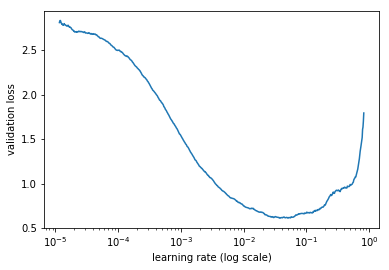

In [48]:
learn.sched.plot()

In [49]:
learn.fit(.01,5)

HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                    
    0      0.440972   0.356697   0.8729    
    1      0.405663   0.336862   0.8767                      
    2      0.377815   0.320734   0.8832                      
    3      0.369465   0.316947   0.8836                      
    4      0.367653   0.314646   0.8868                      



[array([ 0.31465]), 0.88680000000000003]

In [50]:
learn.fit(.01, 5)

HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                    
    0      0.368088   0.298649   0.8906    
    1      0.332542   0.295696   0.8939                      
    2      0.316917   0.290133   0.8932                      
    3      0.330227   0.285923   0.8919                      
    4      0.327285   0.281955   0.893                       



[array([ 0.28195]), 0.89300000000000002]

### Critical that we be able to visualize the results of the model by looking at
* most correctly identified images
* most incorrectly identified images
* repeat above for each of the 10 product categories

In [51]:
data.val_y

array([0, 0, 0, ..., 9, 9, 9])

In [52]:
data.classes

['ankleboot',
 'bag',
 'coat',
 'dress',
 'pullover',
 'sandal',
 'shirt',
 'sneaker',
 'trouser',
 'tshirt']

In [53]:
# predictions of validation set are typically in log scale
log_preds=learn.predict()
preds=np.argmax(log_preds, axis=1)

In [55]:
def rand_by_mask(mask):
    z=np.random.choice(np.where(mask)[0],4,replace=False)
    return list(zip(z,data.val_y[z]))
def rand_by_correct(is_correct):
    return rand_by_mask((preds==data.val_y)==is_correct)
def plots(ims, figsize=(12,6), rows=1, titles=None):
    f=plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp=f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
            plt.imshow(ims[i], cmap='gray')
def load_img_id(ds, idx):
    return np.array(PIL.Image.open(PATH+ds.fnames[idx]))
def plot_val_with_title(idxs, title):
    imgs=[load_img_id(data.val_ds,x) for x,y in idxs]
    title_probs=[np.exp(log_preds[:,y])[x] for x,y in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8))

Correctly Classified


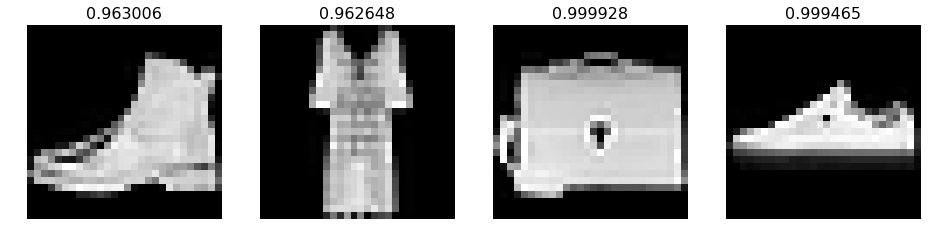

In [91]:
# few correct labels at random
plot_val_with_title(rand_by_correct(True), 'Correctly Classified')

In-Correctly Classified


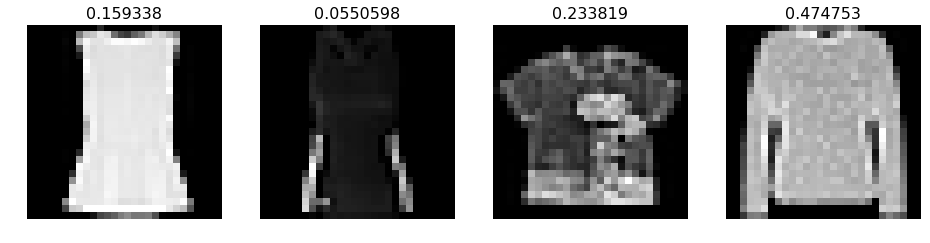

In [90]:
# few incorrect labels at random
plot_val_with_title(rand_by_correct(False), 'In-Correctly Classified')

In [58]:
def most_by_mask(mask,y, is_correct):
    idxs=np.where(mask)[0]
    if is_correct==True:
        z=idxs[np.argsort(np.exp(log_preds[:,y])[idxs])[::-1][:4]]
    else:
        z=idxs[np.argsort(np.exp(log_preds[:,y])[idxs])[:4]]
    return list(zip(z, data.val_y[z]))
def most_by_correct(y, is_correct):
 #   mult=-1 if (y==1)==is_correct else 1
    return most_by_mask(((preds==data.val_y)==is_correct)&(data.val_y==y),y, is_correct)

Most correct ankleboots


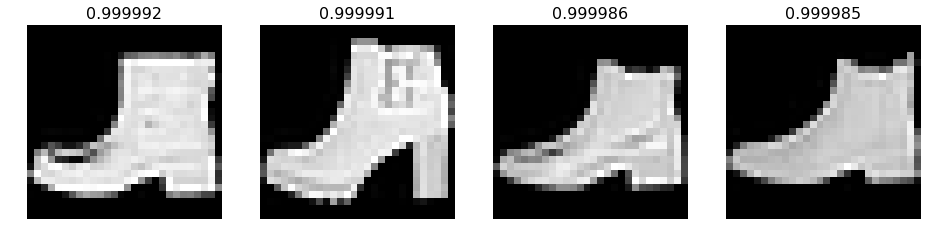

In [92]:
plot_val_with_title(most_by_correct(0, True), "Most correct ankleboots")

Most incorrect ankleboots


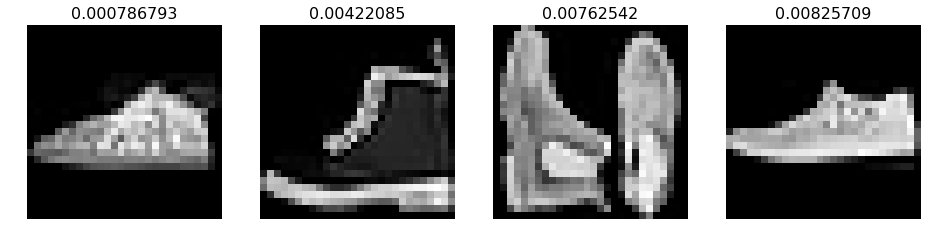

In [93]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect ankleboots")

### Data Augmentations 

* we can improve accuracy by adding more data sometimes

#### However new labeled data is hard to get

* Hence we can resort to image augmentations e.g. randomly changing images without impacting interpretation e.g. flipping, zooming, rotating
* of course the type of augmentation that won't change interpretation is dependent on the images and the problem you are solving
* note that for data augmentations to work the preactivations will need to be recomputed. The preactivations use the resnet34 weights applied to our images and since augmentation adds images we need to re-run by deleting the 'tmp' folder

In [79]:
tfms=tfms_from_model(resnet34, sz, aug_tfms=transforms_side_on, max_zoom=1.1)

In [98]:
data=ImageClassifierData.from_paths(PATH, tfms=tfms)
learn=ConvLearner.pretrained(arch, data, precompute=True)

100%|██████████| 157/157 [00:25<00:00,  6.10it/s]


### LR annealing and Stochastic Gradient Descent with restarts

* As we get close to minimum we should be able to decrease the LR. 
* Implemented as a function (the cosine) -- cosine annealing (half the cosine curve)
* In order to improve generalizability and not get stuck in spikey areas but instead find flat surfaces it would also be good to increase the lr and restart sometimes. This helps jumping around the loss fn. space during gradient descent
* Cycle len refers to the number of epochs in a cycle
* Before this parameter we also specify the # of cycles
* In addition we can specify cycle mult which is a multiplier for cycle length and takes effect at end of each cycle
* so e.g. if cycle len=1 and cycle mult=2 and number of cycles =3 then we will have a total of 7 epochs (1+2+4)

#### finally we can also do something called 'snapshot ensembles' which involve saving weights at the end of each cycle and averaging them at the end


In [99]:
learn.fit(.01,5, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                    
    0      0.462235   0.382153   0.8656    
    1      0.433074   0.349555   0.8744                      
    2      0.404007   0.330518   0.881                       
    3      0.371712   0.326589   0.882                       
    4      0.367714   0.316539   0.8854                      



[array([ 0.31654]), 0.88539999999999996]

In [15]:
# remove tmp instead of setting precompute to False

In [100]:
learn.fit(.01,3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                    
    0      0.380479   0.310637   0.8856    
    1      0.351851   0.307722   0.8881                       
    2      0.355035   0.302783   0.8914                      
    3      0.364926   0.298686   0.8919                       
    4      0.328072   0.298042   0.8904                      
    5      0.316846   0.292832   0.8914                      
    6      0.315641   0.28876    0.8935                      



[array([ 0.28876]), 0.89349999999999996]

In [101]:
learn.unfreeze()

In [102]:
learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 82%|████████▏ | 767/938 [02:07<00:28,  6.04it/s, loss=1.9]  

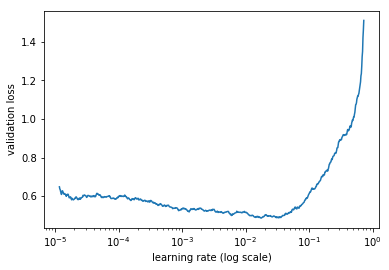

In [103]:
learn.sched.plot()

In [104]:
lr=np.array([1e-5, 1e-4, 1e-1])

In [105]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

  2%|▏         | 23/938 [00:04<02:47,  5.47it/s, loss=0.559]

Exception in thread Thread-53:
Traceback (most recent call last):
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   accuracy                    
    0      0.447202   0.361138   0.8698    
    1      0.43618    0.36703    0.8665                      
    2      0.378764   0.338377   0.8777                      
    3      0.454154   0.362483   0.8672                      
    4      0.393589   0.338833   0.8755                      
    5      0.358693   0.32401    0.8819                      
    6      0.362664   0.321717   0.8823                      



[array([ 0.32172]), 0.88229999999999997]

In [106]:
log_preds, y=learn.TTA()
probs=np.mean(np.exp(log_preds),0)

In [107]:
accuracy_np(probs,y)

0.89810000000000001

In [108]:
preds=np.argmax(probs, axis=1)
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y,preds)

## Confusion matrix for all 10 categories--visual representation

[[952   1   0   0   0   6   0  41   0   0]
 [  0 986   4   1   3   1   2   0   0   3]
 [  0   1 857  30  48   0  62   0   0   2]
 [  0   3  27 900  11   1  38   0   4  16]
 [  0   2  64   9 860   0  58   0   0   7]
 [ 10   0   0   0   0 938   0  52   0   0]
 [  0  14  82  36  55   0 677   0   2 134]
 [ 24   1   0   0   0   5   0 970   0   0]
 [  0   2   2  15   0   0   0   0 979   2]
 [  0  10   7  35  14   0  72   0   0 862]]


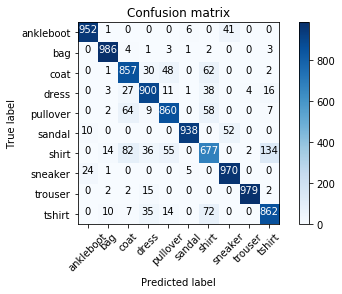

In [109]:
plot_confusion_matrix(cm, data.classes)